In [3]:
import os
from typing import Optional, Union
import gym
import gym.envs.registration
import gym.spaces
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

MAIN = __name__ == "__main__"
max_episode_steps = 1000
IS_CI = os.getenv("IS_CI")
N_RUNS = 200 if not IS_CI else 5

In [27]:
ObsType = int
ActType = int

class MultiArmedBandit(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete
    num_arms: int
    stationary: bool
    arm_reward_means: np.ndarray
    arm_star: int

    def __init__(self, num_arms=10, stationary=True):
        super().__init__()
        self.num_arms = num_arms
        self.stationary = stationary
        self.observation_space = gym.spaces.Discrete(1)
        self.action_space = gym.spaces.Discrete(num_arms)
        self.reset()

    def step(self, arm: ActType) -> tuple[ObsType, float, bool, dict]:
        '''
        Note: some documentation references a new style which has (termination, truncation) bools in place of the done bool.
        '''
        #print(self.action_space)
        #print(arm)
        assert self.action_space.contains(arm)
        if not self.stationary:
            q_drift = self.np_random.normal(loc=0.0, scale=0.01, size=self.num_arms)
            self.arm_reward_means += q_drift
            self.best_arm = int(np.argmax(self.arm_reward_means))
        reward = self.np_random.normal(loc=self.arm_reward_means[arm], scale=1.0)
        obs = 0
        done = False
        info = dict(best_arm=self.best_arm)
        return (obs, reward, done, done, info)

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        super().reset(seed=seed)
        if self.stationary:
            self.arm_reward_means = self.np_random.normal(loc=0.0, scale=1.0, size=self.num_arms)
        else:
            self.arm_reward_means = np.zeros(shape=[self.num_arms])
        self.best_arm = int(np.argmax(self.arm_reward_means))
        if return_info:
            return (0, dict())
        else:
            return 0

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"
        bandit_samples = []
        for arm in range(self.action_space.n):
            bandit_samples += [np.random.normal(loc=self.arm_reward_means[arm], scale=1.0, size=1000)]
        plt.violinplot(bandit_samples, showmeans=True)
        plt.xlabel("Bandit Arm")
        plt.ylabel("Reward Distribution")
        plt.show()

In [28]:
gym.envs.registration.register(
    id="ArmedBanditTestbed-v0",
    entry_point=MultiArmedBandit,
    max_episode_steps=max_episode_steps,
    nondeterministic=True,
    reward_threshold=1.0,
    kwargs={"num_arms": 10, "stationary": True},
)
if MAIN:
    env = gym.make("ArmedBanditTestbed-v0")
    print("Our env inside its wrappers looks like: ", env)

Our env inside its wrappers looks like:  <TimeLimit<OrderEnforcing<PassiveEnvChecker<MultiArmedBandit<ArmedBanditTestbed-v0>>>>>


In [29]:
class Agent:
    '''Base class for agents in a multi-armed bandit environment (you do not need to add any implementation here)'''

    rng: np.random.Generator

    def __init__(self, num_arms: int, seed: int):
        self.num_arms = num_arms
        self.reset(seed)

    def get_action(self) -> ActType:
        raise NotImplementedError()

    def observe(self, action: ActType, reward: float, info: dict) -> None:
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

def run_episode(env: gym.Env, agent: Agent, seed: int):
    (rewards, was_best) = ([], [])
    env.reset(seed=seed)
    agent.reset(seed=seed)
    terminated = False
    truncated = False
    while not (terminated or truncated):
        arm = agent.get_action()
        (obs, reward, terminated, truncated, info) = env.step(arm)
        agent.observe(arm, reward, info)
        rewards.append(reward)
        was_best.append(1 if arm == info["best_arm"] else 0)
    rewards = np.array(rewards, dtype=float)
    was_best = np.array(was_best, dtype=int)
    return (rewards, was_best)

def test_agent(env: gym.Env, agent: Agent, n_runs=200):
    all_rewards = []
    all_was_bests = []
    for seed in tqdm(range(n_runs)):
        (rewards, corrects) = run_episode(env, agent, seed)
        all_rewards.append(rewards)
        all_was_bests.append(corrects)
    return (np.array(all_rewards), np.array(all_was_bests))

class RandomAgent(Agent):
    def get_action(self) -> ActType:
        return self.rng.integers(low=0, high=self.num_arms, size=1)[0]

if MAIN:
    agent = RandomAgent(10, 12345)
    all_rewards, all_bests = test_agent(env, agent)

  0%|          | 0/200 [00:00<?, ?it/s]

In [31]:
all_rewards.shape

(200, 1000)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/curttigges/miniconda3/envs/arena/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'int'>`
  logger.warn(


Frequency of correct arm: 0.11884
Average reward: 0.057534311937154324


  0%|          | 0/200 [00:00<?, ?it/s]

Frequency of correct arm: 0.11984
Average reward: 0.07219959004706576


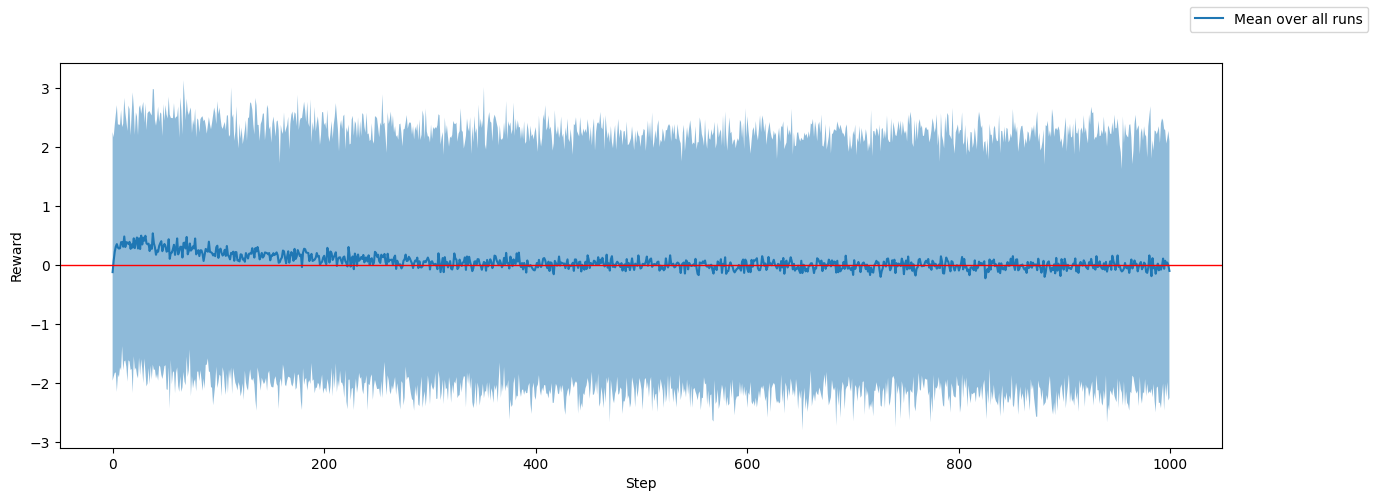

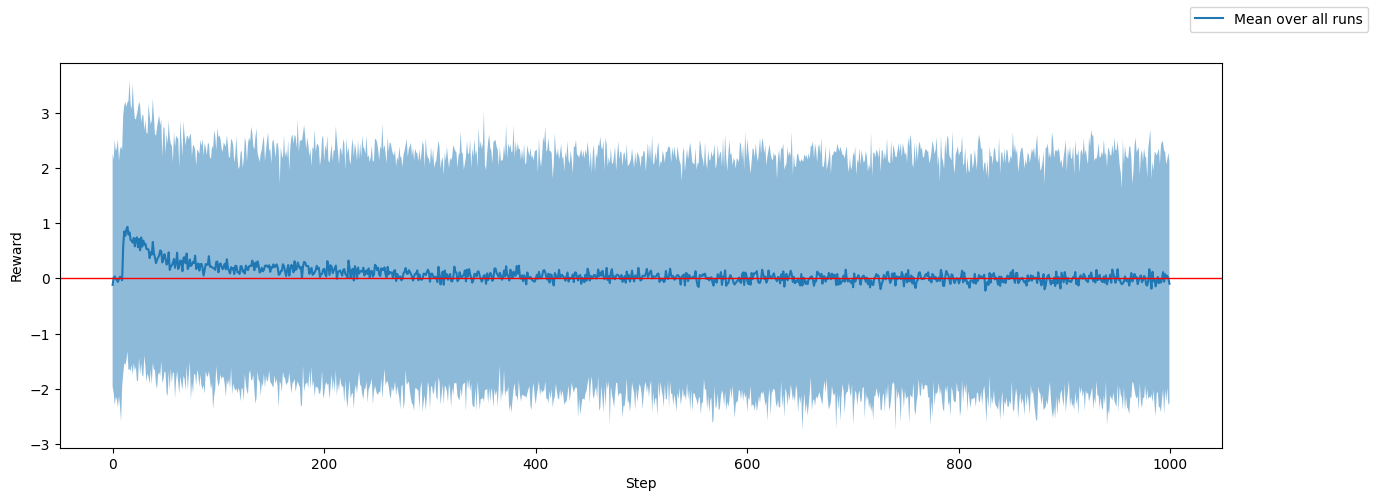

In [43]:
def plot_rewards(all_rewards: np.ndarray):
    (n_runs, n_steps) = all_rewards.shape
    (fig, ax) = plt.subplots(figsize=(15, 5))
    ax.plot(all_rewards.mean(axis=0), label="Mean over all runs")
    quantiles = np.quantile(all_rewards, [0.05, 0.95], axis=0)
    ax.fill_between(range(n_steps), quantiles[0], quantiles[1], alpha=0.5)
    ax.set(xlabel="Step", ylabel="Reward")
    ax.axhline(0, color="red", linewidth=1)
    fig.legend()
    return fig

class RewardAveraging(Agent):
    def __init__(self, num_arms: int, seed: int, epsilon: float, optimism: float):
        super().__init__(num_arms, seed)
        self.epsilon = epsilon
        self.optimism = optimism
        self.num_arms = num_arms

        self.rewards = np.array([self.optimism for n in range(self.num_arms])

    def get_action(self):
        rand_val = self.rng.random()
        if rand_val < self.epsilon:
            action = self.rng.integers(low=0, high=self.num_arms, size=1).item()
        else:
            action = np.argmax(self.rewards)

        return action

    def observe(self, action, reward, info):
        alpha = 1 / self.ks[action] if self.ks[action] != 0 else 1
        self.rewards[action] = self.rewards[action] + alpha * (reward - self.rewards[action])
        self.ks[action] += 1

    def reset(self, seed: int):
        self.rng = np.random.default_rng(seed)
        self.rewards = np.array([self.optimism for n in range(self.num_arms)])
        self.ks = np.zeros(num_arms)

if MAIN:
    num_arms = 10
    stationary = True
    env = gym.make("ArmedBanditTestbed-v0", num_arms=num_arms, stationary=stationary)
    regular_reward_averaging = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=0)
    (all_rewards, all_corrects) = test_agent(env, regular_reward_averaging, n_runs=N_RUNS)
    print(f"Frequency of correct arm: {all_corrects.mean()}")
    print(f"Average reward: {all_rewards.mean()}")
    fig = plot_rewards(all_rewards)
    optimistic_reward_averaging = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=5)
    (all_rewards, all_corrects) = test_agent(env, optimistic_reward_averaging, n_runs=N_RUNS)
    print(f"Frequency of correct arm: {all_corrects.mean()}")
    print(f"Average reward: {all_rewards.mean()}")
    plot_rewards(all_rewards)